# Downloading data from ECCO site

In [1]:
import warnings
warnings.filterwarnings('ignore')

from importlib import reload
from os import listdir,mkdir
import requests
from fsspec.implementations.http import HTTPFileSystem as HTTPFS
#import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
from spectral_analysis.common_vars.directories import MODEL_FOLDER,DATA_FOLDER
#prnt = '{}/LLC2160'.format(MODEL_FOLDER)
prnt = '{}/LLC4320'.format(MODEL_FOLDER)

In [3]:
# Create output folder
def mkdir_ (folder,logError=True):
	#print(folder)
	try:
		mkdir(folder)
		print('Created folder: {}'.format(folder))
	except (FileExistsError):
		if logError:
			print('Folder already exists -- Creation skipped')
		pass

In [4]:
mkdir_(prnt)

Folder already exists -- Creation skipped


In [5]:
def isFolder(url,url_folder):
	forbidden_ch = ['.','?','#',':']
	fname = url.rsplit('/',1)[1]
	if fname=='':
		#print('empty',fname)
		return False
	elif any(c in forbidden_ch for c in fname):
		#print('Forbidden: '+fname)
		return False
	elif len(url.rsplit('?dir=',1))>1:
		#url_parts = url.rsplit('?dir=',1)
		folder = url.rsplit('?dir=',1)[1]
		#print(folder)
		return (url_folder+'/'+fname)==folder
	else:
		return False

In [6]:
# Reading folders from https://data.nas.nasa.gov/ecco/data.php?dir=/eccodata/llc_4320/regions
http_folder = '/eccodata/llc_2160/grid'
prnt_url = 'https://data.nas.nasa.gov/ecco/data.php?dir='+http_folder
download_cmd = 'https://data.nas.nasa.gov/ecco/download_data.php?file='
http_fs = HTTPFS(prnt_url)
#http_fs.ls(prnt_url,detail=False)
regions = [url.rsplit('/',1)[1] for url in http_fs.ls(prnt_url,detail=False) if isFolder(url,http_folder)]
#regions

In [ ]:
region = None
region_folder = None
region_url = None

#https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/
select_region = widgets.Dropdown(
    options=regions,
    #value='2',
    description='Pick a region',
    disabled=False,
)
output_region = widgets.Output()

def on_regionpick(reg):
	if reg.type=='change':
		global region # Allows us to set outer variable
		global region_folder 
		global region_url
		#with output_region:
		region = reg.new
		region_folder = http_folder+"/"+region
		region_url = prnt_url+'/'+region
		print("Selected region: {} ({})".format(region,region_url))

select_region.observe(on_regionpick,names='value')
display(select_region)

In [ ]:
def isVar(url,region_folder):
	fname = url.rsplit('/',1)[1]
	#return fname in ["Eta", "Salt", "Theta", "U", "V", "W","grid"]  
	return fname in ["Eta", "U", "V","grid"]

In [ ]:
def is_downloadable(url,var_folder):
	parts = url.rsplit('?file=',1)
	#print(parts)
	if len(parts)<2:
		return False,None,None
	else:
		fname = url.rsplit("/",1)[1]
		#print(fname)
		#print("Comparing {}/{} AND {}".format(var_folder,fname,parts[1]))
		return (var_folder+'/'+fname)==parts[1],parts[1],fname
		#"""
		#Does the url contain a downloadable resource
		#"""
		#h = requests.head(url, allow_redirects=True)
		#header = h.headers
		#content_type = header.get('content-type')
		#if 'text' in content_type.lower():
		#    return False
		#if 'html' in content_type.lower():
	  #    return False

In [7]:
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

def download_file(varname,url,fname):
    folder = "{}/{}".format(prnt,varname)
    mkdir_(folder,False)
    if fname.endswith(".data") or fname.endswith(".meta"):
        full_fname="{}/{}".format(folder,fname)
    else:
        full_fname="{}/{}.data".format(folder,fname)
    logging.info("Downloading {}".format(url))
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(full_fname, "wb") as handle:
            #for data in tqdm(response.iter_content()):
            handle.write(response.content)
        logging.info("File downloaded into {}".format(full_fname))
    else:
        logging.warning("Response status code: {}".format(response.status_code))

## Descargando malla

In [ ]:
# Esto solo funciona para descargar la malla por separado
var_url = prnt_url
var = "grid"
print(var_url)
var_folder = http_folder
idw = 0
for url_f in http_fs.ls(var_url,detail=False):
    canDownload,fname_path,fname = is_downloadable(url_f,var_folder)
    if canDownload:
        idw = idw+1
        if idw>32:
            download_url = "{}{}".format(download_cmd,fname_path)
            download_file(var,download_url,fname)

In [1]:
from xmitgcm import open_mdsdataset
import numpy as np

/home/antonio/.conda/envs/llc/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/antonio/.conda/envs/llc/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
lds_grid = open_mdsdataset(prnt+'/grid/', read_grid=True, iters=None, default_dtype=np.float32, geometry='llc')
lds_grid

/home/antonio/.conda/envs/llc/lib/python3.6/site-packages/xmitgcm/mds_store.py:846: UserWarning: Couldn't find available_diagnostics.log in /home/antonio/GoogleDrive/Tesis/data/model/LLC4320/grid/ or /home/antonio/GoogleDrive/Tesis/data/model/LLC4320/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG      

In [4]:
XG = lds_grid.XG.isel(face=10).values
YG = lds_grid.YG.isel(face=10).values
XC = lds_grid.XC.isel(face=10).values
YC = lds_grid.YC.isel(face=10).values

In [8]:
print(np.min(XG),np.max(XG))
print(np.min(YG),np.max(YG))

-128.0 -38.00146
13.756127 72.043434


In [31]:
DXG = lds_grid.dxG.isel(face=10).values
DXG.shape

(4320, 4320)

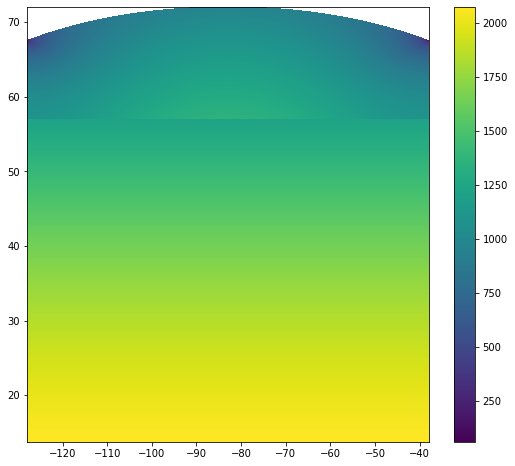

In [35]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(XG,YG,DXG)
plt.colorbar(_cs)
plt.show()

In [36]:
rAc = lds_grid.rA.isel(face=10).values
rAz = lds_grid.rAz.isel(face=10).values

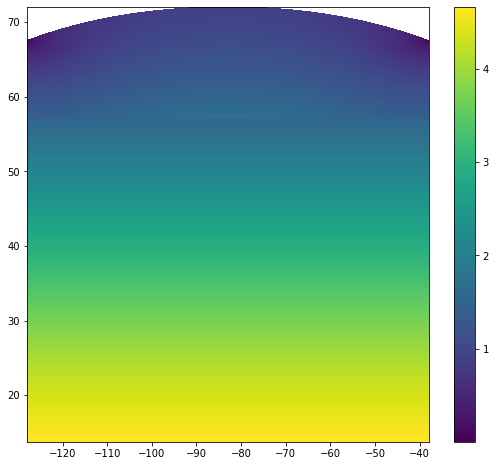

In [39]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(XC,YC,rAz/1000000) # Pasa de m^2 a km^2
plt.colorbar(_cs)
plt.show()

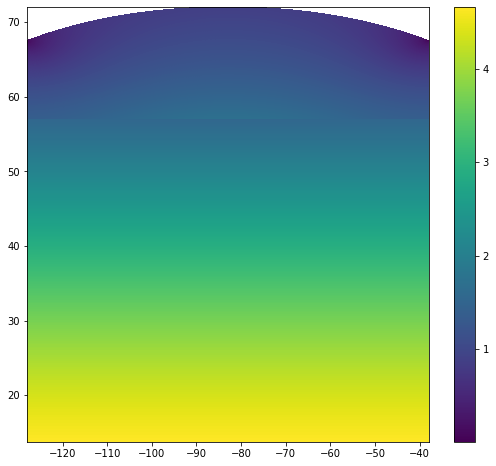

In [43]:
plt.figure(figsize=(9,8))
plt.pcolormesh(XG,YG,rAc/1000000) # Pasa de m^2 a km^2
plt.colorbar()
plt.show()

In [9]:
Zval = [(i,v) for i,v in enumerate(lds_grid.Z.values)] ## z=-500 m está en el índice 40
#lds_grid.Z.values ## z=-500 m está en el índice 39
Zval

[(0, -0.5),
 (1, -1.57),
 (2, -2.79),
 (3, -4.185),
 (4, -5.78),
 (5, -7.595),
 (6, -9.66),
 (7, -12.01),
 (8, -14.68),
 (9, -17.705),
 (10, -21.125),
 (11, -24.99),
 (12, -29.345),
 (13, -34.24),
 (14, -39.725),
 (15, -45.855),
 (16, -52.69),
 (17, -60.28),
 (18, -68.685),
 (19, -77.965),
 (20, -88.175),
 (21, -99.37),
 (22, -111.6),
 (23, -124.915),
 (24, -139.365),
 (25, -154.99),
 (26, -171.825),
 (27, -189.9),
 (28, -209.235),
 (29, -229.855),
 (30, -251.77),
 (31, -274.985),
 (32, -299.505),
 (33, -325.32),
 (34, -352.42),
 (35, -380.79),
 (36, -410.41),
 (37, -441.255),
 (38, -473.305),
 (39, -506.54),
 (40, -540.935),
 (41, -576.465),
 (42, -613.11),
 (43, -650.855),
 (44, -689.685),
 (45, -729.595),
 (46, -770.585),
 (47, -812.66),
 (48, -855.835),
 (49, -900.135),
 (50, -945.595),
 (51, -992.26),
 (52, -1040.18),
 (53, -1089.425),
 (54, -1140.08),
 (55, -1192.235),
 (56, -1246.005),
 (57, -1301.52),
 (58, -1358.92),
 (59, -1418.375),
 (60, -1480.075),
 (61, -1544.225),
 (62, 

In [45]:
dr = [v for v in lds_grid.drC.values]
dr

[0.5,
 1.07,
 1.22,
 1.395,
 1.595,
 1.815,
 2.065,
 2.35,
 2.67,
 3.025,
 3.42,
 3.865,
 4.355,
 4.895,
 5.485,
 6.13,
 6.835,
 7.59,
 8.405,
 9.28,
 10.21,
 11.195,
 12.23,
 13.315,
 14.45,
 15.625,
 16.835,
 18.075,
 19.335,
 20.62,
 21.915,
 23.215,
 24.52,
 25.815,
 27.1,
 28.37,
 29.62,
 30.845,
 32.05,
 33.235,
 34.395,
 35.53,
 36.645,
 37.745,
 38.83,
 39.91,
 40.99,
 42.075,
 43.175,
 44.3,
 45.46,
 46.665,
 47.92,
 49.245,
 50.655,
 52.155,
 53.77,
 55.515,
 57.4,
 59.455,
 61.7,
 64.15,
 66.835,
 69.785,
 73.03,
 76.6,
 80.54,
 84.89,
 89.69,
 95.0,
 100.875,
 107.375,
 114.57,
 122.54,
 131.37,
 141.155,
 152.005,
 164.03,
 177.36,
 192.13,
 208.49,
 226.61,
 246.67,
 268.855,
 293.37,
 320.44,
 350.285,
 383.155,
 419.305,
 458.985,
 239.87]

In [ ]:
plt.figure(figsize=(8,5))
LAT = ds_grid.YC.isel(face=2).values
LON = ds_grid.XC.isel(face=2).values
DEPTH = ds_grid.Depth.isel(face=2).values
_c = plt.contourf(LON,LAT,DEPTH,cmap=plt.cm.Greys_r)
plt.colorbar(_c)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
DX = ds_grid.dxC.isel(face=2).values/2
print(np.min(DX))
print(np.max(DX))
_c = plt.contourf(LON,LAT,DX,25,cmap=plt.cm.Greys_r)
plt.colorbar(_c)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
DY = ds_grid.dyC.isel(face=2).values/2
print(np.min(DY))
print(np.max(DY))
_c = plt.contourf(LON,LAT,DY,50,cmap=plt.cm.Greys_r)
plt.colorbar(_c)
plt.show()

In [ ]:
# Downloading variables from https://data.nas.nasa.gov/ecco/data.php?dir=/eccodata/llc_4320/regions/<region>
# Consider timestamp format: https://github.com/dcherian/tools/blob/master/mitgcm/matlab/cs_grid/read_cs/dte2ts.m
for var in [url.rsplit('/',1)[1] for url in http_fs.ls(region_url,detail=False) if isVar(url,region_folder)]:
	var_url = region_url+"/"+var
	var_folder = region_folder+"/"+var
	print("Reading variable {} ({})".format(var,var_url))
	for url_f in http_fs.ls(var_url,detail=False):
		canDownload,fname_path,fname = is_downloadable(url_f,var_folder)
		if canDownload:
			download_url = "{}{}".format(download_cmd,fname_path)
			download_file(var,download_url,fname)

#print(vars) 

## Leyendo archivos descargados

In [ ]:
#!pip install --upgrade fsspec zarr git+https://github.com/xgcm/xmitgcm.git

In [8]:
from xmitgcm import open_mdsdataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image, HTML


In [9]:
data_shape = (240,577)

In [10]:
#ds_V = np.memmap("{}/{}".format(prnt,"V_tmp"),mode='w+',dtype="float32",shape=(240,577,20))

plt.ion(); plt.figure(1);
#def animate(t_):
for t_ in range(24):
    plt.clf()
    #ax.clear()
    t = t_*10000
    fname_U = "U_240x577x85.20110913T{:06d}.data".format(t)
    fname_V = "V_240x577x85.20110913T{:06d}.data".format(t)
    #print(fname_V)
    U = np.memmap("{}/{}".format(prnt,fname_U),mode='r',dtype='float32',shape=data_shape)
    #V = np.memmap("{}/{}".format(prnt,fname_V),mode='r',dtype='float32',shape=data_shape)
    #UV = np.sqrt(np.square(U) + np.square(V))
    #ax.contour(U)
    #ax.set_title('%06d'%(t))
    #plt.clf()
    plt.contour(U)
    plt.title('%06d'%(t))
    plt.draw()
    del U
    #del V

#fig,ax = plt.subplots()
#ani = animation.FuncAnimation(fig,animate,20,interval=100,blit=False)
#plt.close(ani._fig)
#HTML(ani.to_html5_video())

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disks/LLC4320/GDriveBackup/Tesis/data/model/LLC4320/U_240x577x85.20110913T000000.data'

<Figure size 432x288 with 0 Axes>

In [ ]:
np.fla

# Fetching data directly with LLC tool (xmitgcm.llcreader)

In [11]:
%%script false
import dask,xmitgcm,numpy
print(dask.__version__)
print(xmitgcm.__version__)
print(numpy.__version__)

CalledProcessError: Command 'b'import dask,xmitgcm,numpy\nprint(dask.__version__)\nprint(xmitgcm.__version__)\nprint(numpy.__version__)\n'' returned non-zero exit status 1.

In [12]:
map_res = 48

In [13]:
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from xmitgcm import llcreader
if map_res==24:
    model = llcreader.ECCOPortalLLC2160Model()
elif map_res==48:
    model = llcreader.ECCOPortalLLC4320Model()
else:
    raise Exception("Invalid resolution")
model.varnames

['Eta',
 'KPPhbl',
 'oceFWflx',
 'oceQnet',
 'oceQsw',
 'oceSflux',
 'oceTAUX',
 'oceTAUY',
 'PhiBot',
 'Salt',
 'SIarea',
 'SIheff',
 'SIhsalt',
 'SIhsnow',
 'SIuice',
 'SIvice',
 'Theta',
 'U',
 'V',
 'W']

In [ ]:
cols2drop = ['time']
map_mode = 'faces' # 'faces' or 'latlon'

if map_mode=='faces':
    cols2drop=['time','niter','face']
    cols2drop_uv=['time','niter','face','k']
    cols2drop_w=['time','niter','face','k_l']

In [ ]:
model_vars = ["Eta","U","V","W"]
#ds = model.get_dataset(varnames=model_vars,type='latlon',k_levels=[0,29,59,89],iter_start=10368,iter_stop=11368,iter_step=80,k_chunksize=1) # delta_t = 45 s, 80*45=3600 s = 1h
ds = model.get_dataset(varnames=model_vars,k_levels=[0,29,59,89],k_chunksize=1,type=map_mode)
ds

In [ ]:
ds.time.values

In [ ]:
ds.nbytes / (1024*1024*1024) # En GB

## Tomando la parte de Canarias

Al tomar los datos al estilo _faces_, podemos elegir [una de las 13 caras](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html) (_faces_ o _tiles_), para ahorrar memoria al momento de cargarla.

**La corriente de Benguela está en la cara 2**.



In [ ]:
area_face=2

In [ ]:
ds_eta = ds.Eta.isel(time=0,face=area_face)
ds_eta

In [ ]:
# Índices para longitud (i) y latitud (j) -- necesitamos convertirlos a grados (lat-lon)
i = ds_eta.i.values
j = ds_eta.j.values


In [ ]:
ds_eta.nbytes / (1024*1024*1024) # Tamaño en GB

In [ ]:
df_pd = ds_eta.to_dataframe()
df_pd.reset_index(inplace=True)
df_pd.head()

In [ ]:
# Eliminamos el tiempo por ahora, ya que es igual
# Al hacer pivot_table, le damos la forma de matriz
#df = dd.from_pandas(df_pd,npartitions=4*multiprocessing.cpu_count()).drop('time',axis=1)
#df = df.categorize(columns=['i']).pivot_table(index='j',columns='i',values='Eta')
#df.head()

In [ ]:
## Version sin Dask de lo mismo
df = df_pd.drop(cols2drop,axis=1).pivot_table(index='j',columns='i',dropna=False)
print(df.shape)
df.head()

In [ ]:
vals_np = df.values
vals_np.shape

In [ ]:
print(len(i))
print(len(j))

In [ ]:
plt.contourf(i,j,vals_np,50)
plt.show()

### Conversión de índices a latitud-longitud

Necesitamos "convertir" los índices (i,j) a (lon,lat)

La caja 2 tiene los siguientes rangos (aproximados):
 - Longitud: -35 a 55 (90 grados)
 - Latitud: 13.5 a 71 (57.5 grados)

In [ ]:
# La longitud es sencilla de convertir
min_lon = -35
lon = min_lon+i/map_res

lon_i = ((lon_,i_,1/map_res) for lon_,i_ in zip(lon,i))
lon_i_df = pd.DataFrame(lon_i,columns=["lon","i","d_lon"])
lon_i_df.set_index("lon",inplace=True)
lon_i_df.head()

In [ ]:
j.shape

In [ ]:
min_lat = 13.5
#max_lat = 71 # Algo así deberíamos de obtener en max(lat)
lat = np.zeros((len(j),))
lat[0] = min_lat
del_lat = np.zeros((len(j),))
del_lat[0] = np.cos(min_lat*np.pi/180)/map_res
for jj in range(1,len(j)):
    del_lat[jj] = np.cos(lat[jj-1]*np.pi/180)/map_res
    lat[jj] = lat[jj-1] + del_lat[jj]
print(min(lat))
print(max(lat))

lat_j = ((lat_,j_,dlat) for lat_,j_,dlat in zip(lat,j,del_lat))
lat_j_df = pd.DataFrame(lat_j,columns=["lat","j","d_lat"])
lat_j_df.set_index("lat",inplace=True)
lat_j_df.head()

In [ ]:
plt.contourf(lon,lat,vals_np,50)
plt.show()

### Usamos la conversión para seleccionar la región que nos interesa

Tomaremos, por ejemplo, la caja 771, ya que vemos una clara partición BM/IGW cerca a los 60 km.

La caja está centrada en lon=-23, y lat=31.462

Para ser más exactos, usaremos los límites calculados previamente

In [ ]:
area_id = 771

In [ ]:
# Directorio de los datos geográficos
prnt_map = '{}/by_region'.format(DATA_FOLDER)
geodata = gpd.read_file('{}/{}_{}_geo.json'.format(prnt_map,'RV',"ASO"),driver='GeoJSON')
data_area = geodata[geodata["s_id"]==area_id].drop(columns=["season","var"])
data_area

In [ ]:
area_box = data_area['geometry'].values[0]
lon_min,lat_min,lon_max,lat_max = area_box.bounds
print(area_box.bounds)
#lon_min=-26
#lon_max = -24
#lat_min = 32.8
#lat_max = 33.8

In [ ]:
i_area = lon_i_df[lon_min:lon_max]["i"].values
j_area = lat_j_df[lat_min:lat_max]["j"].values

In [ ]:
print(len(i_area))
print(len(j_area))

In [ ]:
lon_area = lon_i_df[lon_min:lon_max].index.values
lat_area = lat_j_df[lat_min:lat_max].index.values

In [ ]:
#
min_i = i_area[0]
max_i = i_area[-1]
min_j = j_area[0]
max_j = j_area[-1]
#

In [ ]:
ds_area = ds.isel(face=area_face,
                  i=slice(min_i,max_i+1),j=slice(min_j,max_j+1),
                  i_g=slice(min_i,max_i+1),j_g=slice(min_j,max_j+1)
                  )
ds_area

In [ ]:
ds_area.nbytes / (1024*1024*1024) # En GB

#### Tomamos variable por variable, en t=0

##### U, z=0

In [ ]:
ds_u = ds_area.U.isel(time=0,k=0)
ds_u

In [ ]:
df_u_pd = ds_u.to_dataframe()
df_u_pd.reset_index(inplace=True)
df_u_pd.head()

In [ ]:
set(df_u_pd["k"].values)

In [ ]:
df_u = df_u_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j',columns='i_g',dropna=False)
print(df_u.shape)
df_u.head()

In [ ]:
vals_u = df_u.values
print(vals_u.shape)
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,vals_u)
plt.colorbar(_cs)
plt.show()

##### V, z=0

In [ ]:
df_v_pd = ds_area.V.isel(time=0,k=0).to_dataframe()
df_v_pd.reset_index(inplace=True)
df_v = df_v_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j_g',columns='i',dropna=False)
vals_v = df_v.values
print(vals_v.shape)
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,vals_v)
plt.colorbar(_cs)
plt.show()

##### Velocidad en z=0

In [ ]:
U = np.sqrt(np.square(vals_u) + np.square(vals_v))

In [ ]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,U,cmap=plt.cm.Blues_r)
plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='white')
plt.colorbar(_cs)
plt.show()

##### Energía cinética (KE) en z=0

In [ ]:
KE = np.square(U)/2

In [ ]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,KE,cmap=plt.cm.Blues_r)
#plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='white')
plt.colorbar(_cs)
plt.show()

###### Transformada de Fourier de KE

Ver [pregunta en SO](https://dsp.stackexchange.com/questions/724/low-pass-filter-and-fft-for-beginners-with-python/725#725) para información sobre consideraciones en el uso de un filtro "ideal"

In [ ]:
max_dx = np.max(dxdy)
min_dx = np.min(dxdy)
print(max_dx)
print(min_dx)
print("Diferencia entre intervalos de muestreo: {0:.2f}%".format(100*(max_dx-min_dx)/max_dx))
# Esta diferencia porcentual nos permite hacer la FFT como si los puntos estuvieran en una malla cuadriculada
dxdy_avg = (max_dx + min_dx)/2
print("Usaremos un delta_xy promedio de {0:.3f} km".format(dxdy_avg/1000))

In [ ]:
Nx = len(lon_area)
Lx = Nx*dxdy_avg
delta_kx = 1/Lx
Ny = len(lat_area)
Ly = Ny*dxdy_avg
delta_ky = 1/Ly

print("Se hace la FFT en una región cuadrangular de ~ {0:.2f} x {1:.2f} km, o {2}x{3} puntos".format(Lx/1000,Ly/1000,Nx,Ny))

In [ ]:
KE_k = np.fft.fft2(KE)
KE_k_plt = np.fft.fftshift(KE_k)

In [ ]:
N_kx = (Nx-1)/2
Kx = delta_kx*np.arange(-N_kx,N_kx+1)
N_ky = (Ny-1)/2
Ky = delta_ky*np.arange(-N_ky,N_ky+1)
print(len(Kx))
print(len(Ky))
print(1/(delta_kx*N_kx))

In [ ]:
plt.figure(figsize=(9,7))
_c = plt.pcolormesh(Kx,Ky,np.log(np.abs(KE_k_plt)))
plt.colorbar(_c)
plt.show()

###### Partimos los movimientos en largos y cortos

In [ ]:
## Elegimos la longitud de onda a la que filtraremos
L_max = 50*1000 # 50 km, digamos
K_max = 1/L_max
kx_,ky_ = np.meshgrid(Kx,Ky)

# Las variables _plt solo se usan de forma auxiliar para las gráficas (plot)
filter_mask_plt = (np.square(kx_)+np.square(ky_) <= K_max**2).astype(np.float32)
filter_mask = np.fft.fftshift(filter_mask_plt)
filter_mask = filter_mask*np.fliplr(filter_mask) # Simetria en Kx
filter_mask = filter_mask*np.flipud(filter_mask) # Simetria en Ky

In [ ]:
plt.figure(figsize=(9,7))
_c = plt.pcolormesh(Kx,Ky,filter_mask_plt)
plt.colorbar(_c)
plt.show()

In [ ]:
# El cálculo de la inversa se hará sobre la variable a la que no se le aplica fftshift,
# ya que np.flipup y np.fliplr no conmutan con fftshift
KE_k_lo = KE_k*filter_mask
KE_k_hi = KE_k-KE_k_lo
#
KE_k_lo_plt = KE_k_plt*filter_mask_plt
KE_k_hi_plt = KE_k_plt-KE_k_lo_plt

In [ ]:
# Forzamos que las matrices sean hermíticas
#idx_k = int((Nx-Ny)/2)
#KE_k_lo[:,idx_k:-idx_k] = (KE_k_lo[:,idx_k:-idx_k] + KE_k_lo[:,idx_k:-idx_k].T.conj())/2
#KE_k_hi[:,idx_k:-idx_k] = (KE_k_hi[:,idx_k:-idx_k] + KE_k_hi[:,idx_k:-idx_k].T.conj())/2

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c = ax1.pcolormesh(Kx,Ky,np.log(np.abs(KE_k_lo_plt)))
_c = ax2.pcolormesh(Kx,Ky,np.log(np.abs(KE_k_hi_plt)))
#ax2.colorbar(_c)
fig.show()

###### Transformada inversa

In [ ]:
_KE_lo = np.fft.ifft2(KE_k_lo)
_KE_hi = np.fft.ifft2(KE_k_hi)

print(np.max(np.abs(np.real(_KE_lo))))
print(np.max(np.abs(np.imag(_KE_lo))))
print(np.max(np.abs(np.real(_KE_hi))))
print(np.max(np.abs(np.imag(_KE_hi))))

In [ ]:
KE_lo = np.real(_KE_lo)
KE_hi = np.real(_KE_hi)

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c = ax1.pcolormesh(lon_area,lat_area,KE_lo)
_c = ax2.pcolormesh(lon_area,lat_area,KE_hi)
#ax2.colorbar(_c)
fig.show()

###### Verificamos el error inducido

In [ ]:
KE_rec = KE_lo + KE_hi # KE "reconstruida"
KE_diff = np.abs(100*(KE-KE_rec)/KE) # Error relativo porcentual

In [ ]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,KE_diff,cmap=plt.cm.Greys_r)
plt.colorbar(_cs)
plt.show()

##### Prueba: cálculo de derivadas en ambas direcciones



In [ ]:
tt = np.array([i for i in range(100)])
xy = np.cos(tt*2*np.pi/50)
zz = np.outer(xy,xy)

In [ ]:
gradxy = np.gradient(zz)
gradx = gradxy[1] # gradient(zz,axis=0) hace la derivada sobre el eje 0 (las filas), es decir sobre X
grady = gradxy[0] # gradient(zz,axis=1) hace la derivada sobre el eje 1 (las columnas), es decir sobre Y
#gradx = np.gradient(zz,axis=1)
#grady = np.gradient(zz,axis=0)

In [ ]:
plt.figure(figsize=(9,7))
_c = plt.contourf(tt,tt,zz)
plt.quiver(tt[::5],tt[::5],gradx[::5,::5],grady[::5,::5])
plt.colorbar(_c)
plt.show()

##### Vorticidad planetaria

In [ ]:
R = 6371*1000 # Radio de la Tierra, en metros
C = 2*np.pi*R # Circunferencia en el Ecuador
Omega = 2*np.pi/(24*3600) # Frecuencia de rotación terrestre
print(Omega)

In [ ]:
cos_lat = np.tile(np.cos(lat_area*np.pi/180).reshape((len(j_area),1)),(1,len(i_area)))

In [ ]:
# Parámetro de coriolis: f = 2*Omega*cos(latitud)
f_cor = 2*Omega*cos_lat

In [ ]:
_c = plt.pcolormesh(lon_area,lat_area,f_cor)
plt.colorbar(_c)
plt.show()

##### Vorticidad relativa en z=0

In [ ]:
dxdy = C*cos_lat/map_res/360

RV_0 = (np.gradient(vals_v,axis=1) - np.gradient(vals_u,axis=0))/dxdy

In [ ]:
plt.figure(figsize=(10,8))
divnorm = colors.DivergingNorm(vmin=np.min(RV_0), vcenter=0, vmax=np.max(RV_0))

_cs = plt.pcolormesh(lon_area,lat_area,RV_0,norm=divnorm,cmap=plt.cm.coolwarm) # plt.cm.RdBu
plt.colorbar(_cs)
plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='gray')
plt.show()

##### Estiramiento en z=0

###### $\sigma_n$

In [ ]:
sigma_n = (np.gradient(vals_u,axis=1) - np.gradient(vals_v,axis=0))/dxdy

In [ ]:
divnorm = colors.DivergingNorm(vmin=np.min(sigma_n), vcenter=0, vmax=np.max(sigma_n))

plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,sigma_n,norm=divnorm,cmap=plt.cm.RdBu_r)
plt.colorbar(_cs)
plt.show()

###### $\sigma_s$

In [ ]:
sigma_s = (np.gradient(vals_v,axis=1) + np.gradient(vals_u,axis=0))/dxdy

In [ ]:
divnorm = colors.DivergingNorm(vmin=np.min(sigma_s), vcenter=0, vmax=np.max(sigma_s))
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,sigma_s,norm=divnorm,cmap=plt.cm.RdBu_r)
plt.colorbar(_cs)
plt.show()

###### $\sigma_n^2 + \sigma_s^2$

In [ ]:
sigma_sq = np.square(sigma_n) + np.square(sigma_s)

In [ ]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,sigma_sq,cmap=plt.cm.Blues_r)
plt.colorbar(_cs)
plt.show()

##### Okubo-Weiss en z=0

In [ ]:
RV_sq = np.square(RV_0)
OW = (sigma_sq - RV_sq)/4

In [ ]:
plt.figure(figsize=(9,8))
divnorm = colors.DivergingNorm(vmin=np.min(OW), vcenter=0, vmax=np.max(OW))

_cs = plt.pcolormesh(lon_area,lat_area,OW,norm=divnorm,cmap=plt.cm.RdBu_r)
plt.colorbar(_cs)
plt.show()

##### W en z=0

In [ ]:
df_w_pd = ds_area.W.isel(time=0,k_l=0).to_dataframe()
df_w_pd.reset_index(inplace=True)
df_w = df_w_pd.drop(cols2drop_w,axis=1).pivot_table(index='j',columns='i',dropna=False)
vals_w = df_w.values

In [ ]:
print(vals_w.shape)
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,vals_w)
plt.colorbar(_cs)
plt.show()

##### Número de Rossby baroclínico, con H=500 m

$Ro_b = \left|\frac{\zeta_b}{f}\right|$

con $\zeta_b = \zeta_{z=0 m} - \zeta_{z=-500 m}$

In [ ]:
# U en z=-500 m
df_uH_pd = ds_area.U.isel(time=0,k=1).to_dataframe() ## Supondremos que 500m está en k=29
df_uH_pd.reset_index(inplace=True)
df_uH = df_vH_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j_g',columns='i',dropna=False)
vals_uH = df_uH.values

In [ ]:
# V en z=-500 m
df_vH_pd = ds_area.V.isel(time=0,k=1).to_dataframe() ## Supondremos que 500m está en k=29
df_vH_pd.reset_index(inplace=True)
df_vH = df_vH_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j_g',columns='i',dropna=False)
vals_vH = df_vH.values

In [ ]:
RV_H = (np.gradient(vals_vH,axis=1) - np.gradient(vals_uH,axis=0))/dxdy

In [ ]:
Ro_b = np.abs((RV_0-RV_H)/f_cor)

In [ ]:
plt.figure(figsize=(10,8))

_cs = plt.pcolormesh(lon_area,lat_area,Ro_b,cmap=plt.cm.Blues_r)
plt.colorbar(_cs)
#plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='white')
plt.show()